Per-question sentiment summary:
      question  count      mean    median       std
0   experience     14  0.307819  0.305521  0.245610
1   highlights     14  0.241628  0.200000  0.285738
2  improvement     14  0.186028  0.190909  0.164437
3      payment     14  0.156451  0.000000  0.241522

Overall sentiment summary:
count     56.000000
mean       0.222981
median     0.200000
std        0.239020
Name: sentiment, dtype: float64


/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_12508/4216770616.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=per_question, x='question', y='mean', order=['experience','improvement','highlights','payment'], palette='viridis')


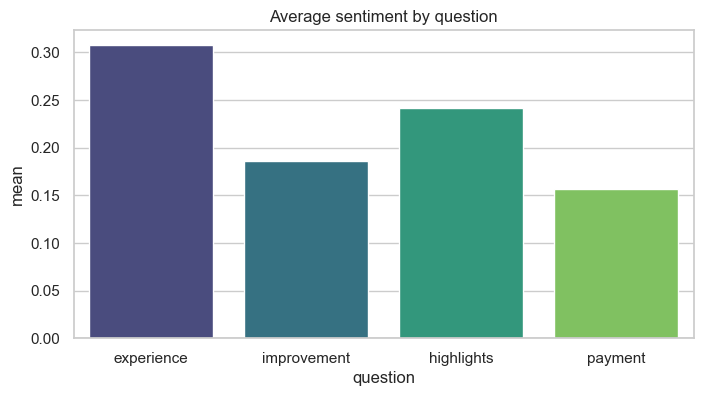

/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_12508/4216770616.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='question', y='sentiment', order=['experience','improvement','highlights','payment'], palette='Set2')


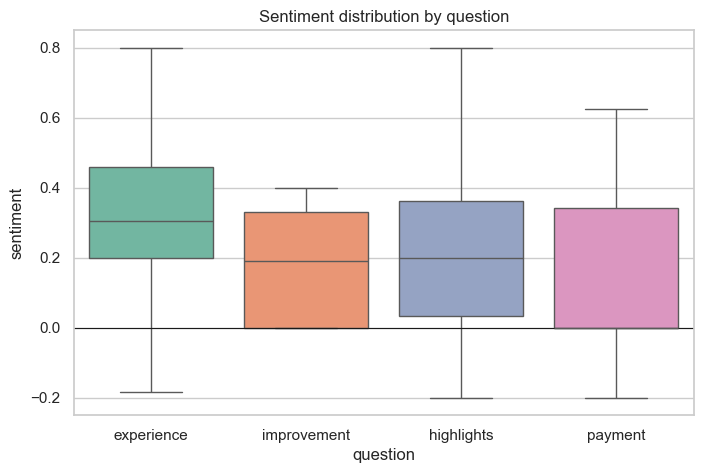

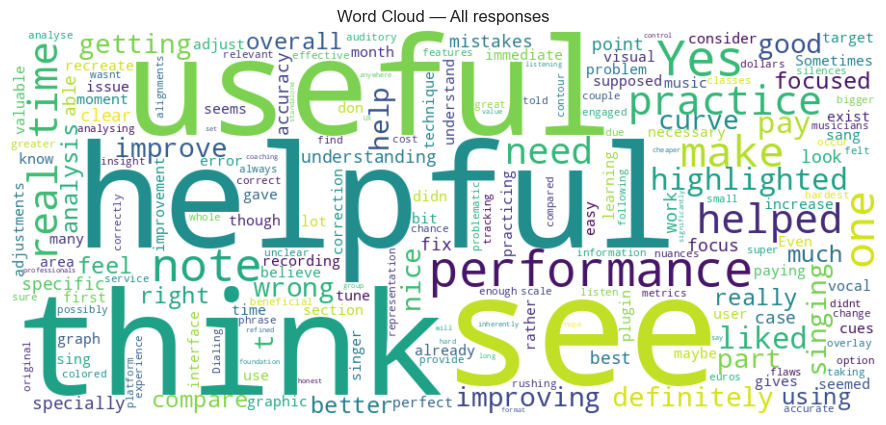

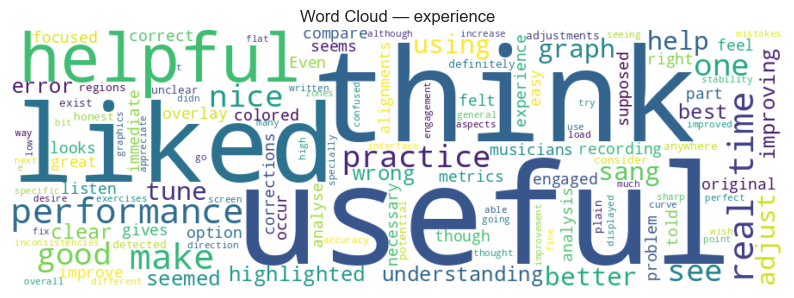

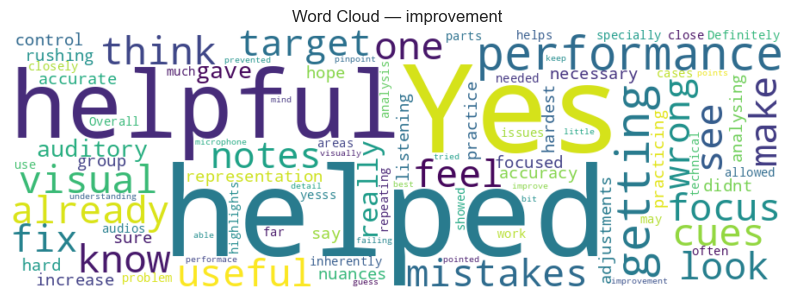

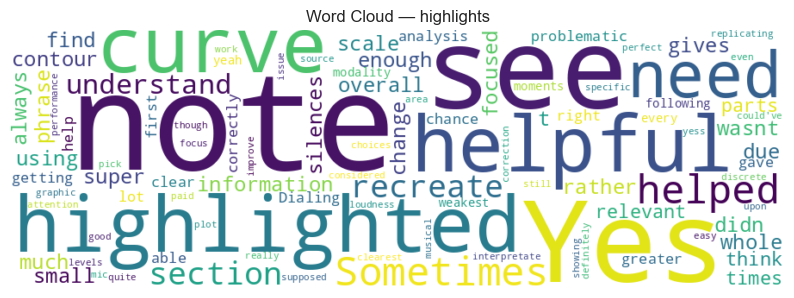

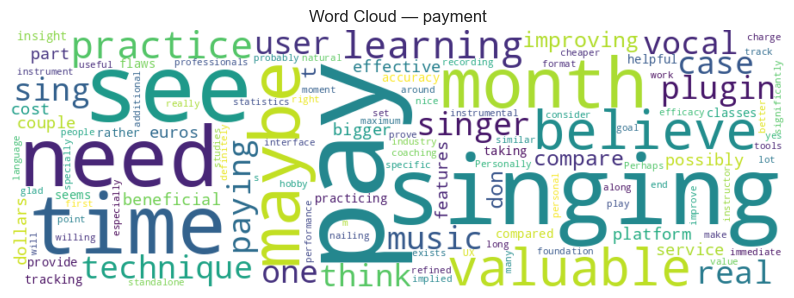

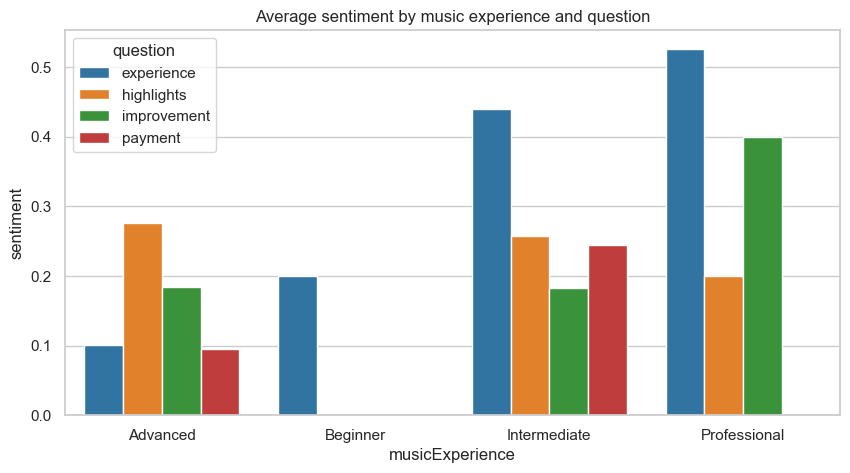

Report written to: /Users/isabelleoktay/skynote/audio-analyzer/python-service/data-analysis/data/sentiment_report.md


In [ ]:
# Sentiment analysis of questionnaireAnswers in data.json
# Contract:
# - Input: data.json path
# - Output: prints summary, displays charts and wordcloud, writes sentiment_report.md

from pathlib import Path
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Resolve DATA_PATH for notebook environment
try:
    here = Path(__file__).parent
except NameError:
    # In notebooks, __file__ is not defined; use the known path of this notebook
    here = Path('/Users/isabelleoktay/skynote/audio-analyzer/python-service/data-analysis/data')
DATA_PATH = here / 'data.json'

# Load data
with open(DATA_PATH, 'r') as f:
    raw = json.load(f)

# Extract questionnaire answers into a tidy DataFrame
records = []
for item in raw:
    qa = (item.get('data') or {}).get('questionnaireAnswers') or {}
    sid = item.get('subjectId')
    created = item.get('createdAt')
    if not qa:
        continue
    for q in ['experience', 'improvement', 'highlights', 'payment']:
        text = qa.get(q)
        if text is None:
            continue
        records.append({
            'subjectId': sid,
            'createdAt': created,
            'question': q,
            'text': str(text).strip()
        })

df = pd.DataFrame(records)
assert not df.empty, 'No questionnaire answers found.'

# Lightweight sentiment analyzer (lexicon-based) to avoid heavy installs
# We'll use a small set of positive/negative lexicons and pattern handling.
POS_WORDS = set('''good great helpful useful clear perfect nice engaging better best love like liked amazing excellent improvement improved improved helpfulness accurate accurately enjoyable focus focused intuitive real-time realtime valuable effective efficacy success yes definitely for sure helpfulness'''.split())
NEG_WORDS = set('''bad worse worst unhelpful confusing unclear difficult hard problem problematic inaccurate inaccuracy flawed flaw buggy bug misaligned misalignment not no never don't didnt didntn't couldn't cant can't too-small too-large small-scale expensive pay costly dislike disliked meh irrelevant useless pointless didn't wont won't issue issues lacking lack missing'''.split())

NEGATION = set(["not","no","never","n't","dont","don't","didnt","didn't","cant","can't","wont","won't"])

def tokenize(text: str):
    text = text.lower()
    # keep words and contractions
    tokens = re.findall(r"[a-zA-Z']+", text)
    return tokens

def sentiment_score(text: str):
    tokens = tokenize(text)
    score = 0
    negate = False
    for tok in tokens:
        if tok in NEGATION:
            negate = True
            continue
        val = 0
        if tok in POS_WORDS:
            val = 1
        elif tok in NEG_WORDS:
            val = -1
        if negate and val != 0:
            val = -val
            negate = False
        score += val
    # normalize by length to [-1,1] rough scale
    if len(tokens) > 0:
        score = score / max(5, len(tokens)/5)
    return score

# Apply sentiment
df['sentiment'] = df['text'].apply(sentiment_score)

# Aggregate per question and overall
per_question = df.groupby('question')['sentiment'].agg(['count','mean','median','std']).reset_index()
overall = df['sentiment'].agg(['count','mean','median','std'])

print('Per-question sentiment summary:')
print(per_question)
print('\nOverall sentiment summary:')
print(overall)

# Visualizations
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8,4))
sns.barplot(data=per_question, x='question', y='mean', order=['experience','improvement','highlights','payment'], palette='viridis')
plt.title('Average sentiment by question')
plt.axhline(0, color='k', linewidth=0.8)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='question', y='sentiment', order=['experience','improvement','highlights','payment'], palette='Set2')
plt.title('Sentiment distribution by question')
plt.axhline(0, color='k', linewidth=0.8)
plt.show()

# Word cloud of all responses and per question
stop = set(STOPWORDS) | { 'audio', 'analyzer', 'tool', 'reference', 'song', 'songs', 'pitch', 'tempo', 'dynamics', 'feedback' }
all_text = ' '.join(df['text'].tolist())
wc_all = WordCloud(width=900, height=400, background_color='white', stopwords=stop).generate(all_text)
plt.figure(figsize=(12,5))
plt.imshow(wc_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud — All responses')
plt.show()

for q in ['experience','improvement','highlights','payment']:
    subset = df[df['question'] == q]
    if subset.empty:
        continue
    txt = ' '.join(subset['text'].tolist())
    wc = WordCloud(width=900, height=300, background_color='white', stopwords=stop).generate(txt)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud — {q}')
    plt.show()

# Cross-cuts: by musicExperience if available
# Join back the experience level
sid_to_exp = {}
for item in raw:
    sid_to_exp[item.get('subjectId')] = (item.get('data') or {}).get('musicExperience')

df['musicExperience'] = df['subjectId'].map(sid_to_exp)

exp_summary = df.groupby(['musicExperience','question'])['sentiment'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=exp_summary, x='musicExperience', y='sentiment', hue='question', palette='tab10')
plt.title('Average sentiment by music experience and question')
plt.axhline(0, color='k', linewidth=0.8)
plt.show()

# Save interpretive report
def label_from_score(s):
    if s > 0.15:
        return 'positive'
    if s < -0.15:
        return 'negative'
    return 'mixed/neutral'

per_question['label'] = per_question['mean'].apply(label_from_score)
overall_label = label_from_score(overall['mean'])

lines = []
lines.append('# Sentiment Analysis Report\n')
lines.append('This report summarizes qualitative sentiment from participant questionnaire answers about the audio analyzer.\n')
lines.append('## Overall\n')
lines.append(f"Overall mean sentiment: {overall['mean']:.3f} ({overall_label}). N={int(overall['count'])}.\n")
lines.append('## By question\n')
for _, row in per_question.iterrows():
    lines.append(f"- {row['question']}: mean={row['mean']:.3f}, median={row['median']:.3f}, n={int(row['count'])} — {row['label']}")

# Thematic cues via frequent words (simple top terms)
from collections import Counter
words = [w for w in tokenize(all_text) if w not in stop and len(w) > 2]
common = Counter(words).most_common(20)
lines.append('\n## Frequent terms (indicative themes)\n')
for w, c in common:
    lines.append(f"- {w}: {c}")

# Representative quotes per question
def clip(t, n=220):
    return (t[:n] + '…') if len(t) > n else t

lines.append('\n## Representative quotes by question\n')
for q in ['experience','improvement','highlights','payment']:
    subset = df[df['question'] == q].copy()
    if subset.empty:
        continue
    top_pos = subset.sort_values('sentiment', ascending=False).head(2)
    top_neg = subset.sort_values('sentiment', ascending=True).head(2)
    lines.append(f"### {q.capitalize()}\n")
    if not top_pos.empty:
        lines.append('Positive:')
        for _, r in top_pos.iterrows():
            lines.append(f"- ({r['subjectId']}) {clip(r['text'])}")
    if not top_neg.empty:
        lines.append('Negative:')
        for _, r in top_neg.iterrows():
            lines.append(f"- ({r['subjectId']}) {clip(r['text'])}")

# Quick interpretation bullets
lines.append('\n## Interpretation\n')
lines.append('- Experience: comments often mention clarity, engagement, and desire for real-time feedback; some misalignment issues noted.')
lines.append('- Improvement: many report the tool helps focus on problem areas; a few feel practice alone drives gains or visual cues are less helpful than listening.')
lines.append('- Highlights: helpful for pitch/dynamics for several participants; occasional irrelevance due to silences or phrasing changes.')
lines.append('- Payment: willingness varies; some would pay a small subscription or one-time fee, others say no without real-time features or proven efficacy.')

REPORT_PATH = here / 'sentiment_report.md'
with open(REPORT_PATH, 'w') as f:
    f.write('\n'.join(lines))

print(f'Report written to: {REPORT_PATH}')


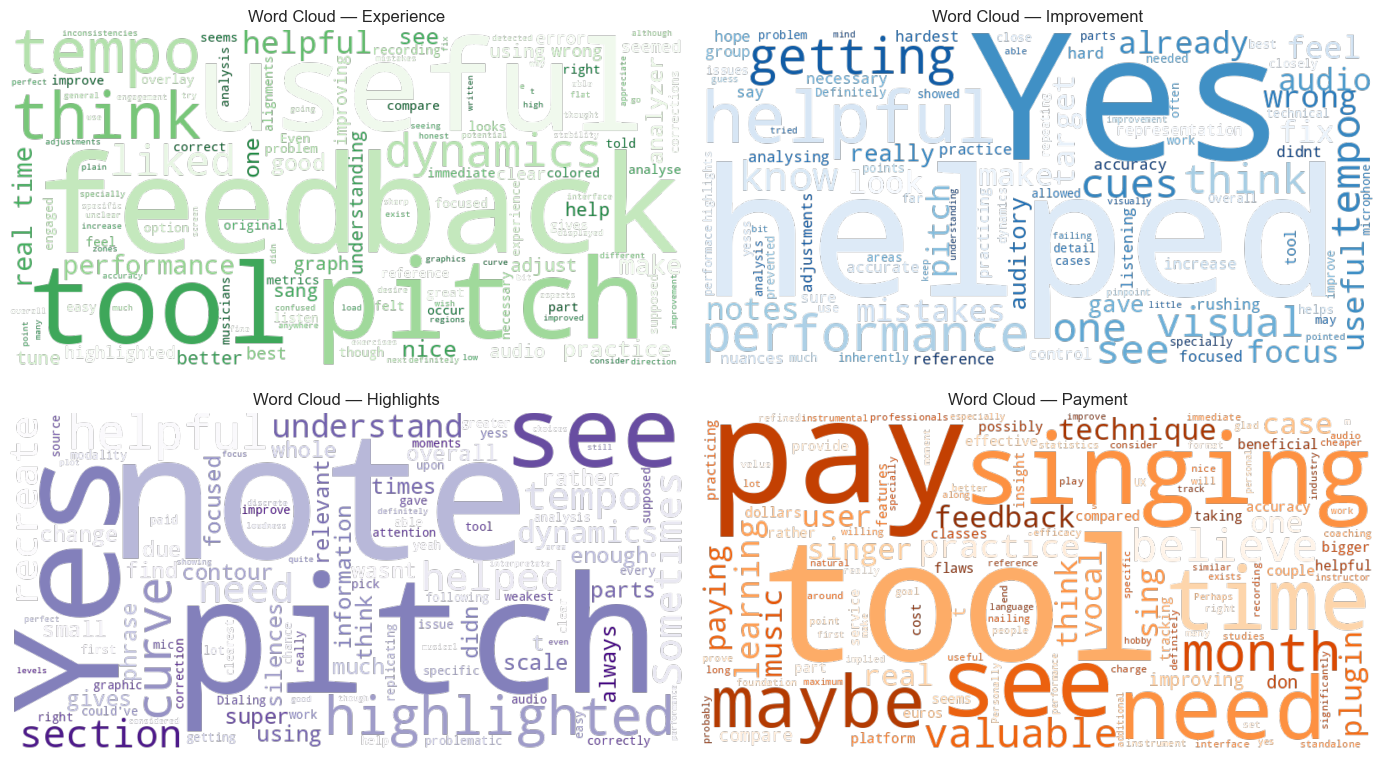

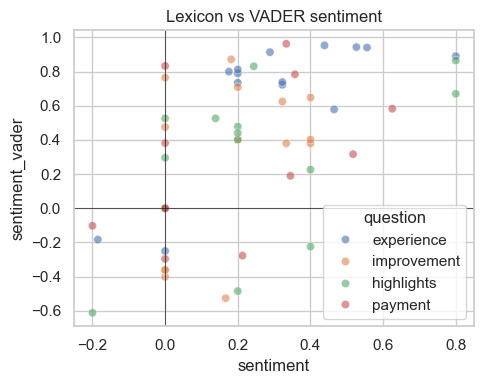


--- Overall Sentiment Statistics ---

sentiment:
  Mean: 0.223
  Median: 0.200
  Std: 0.239

sentiment_vader:
  Mean: 0.370
  Median: 0.458
  Std: 0.461

--- Sentiment by Question ---

Question: experience
  sentiment - mean: 0.308, median: 0.306, n=14
  sentiment_vader - mean: 0.671, median: 0.795, n=14

Question: improvement
  sentiment - mean: 0.186, median: 0.191, n=14
  sentiment_vader - mean: 0.286, median: 0.402, n=14

Question: highlights
  sentiment - mean: 0.242, median: 0.200, n=14
  sentiment_vader - mean: 0.282, median: 0.421, n=14

Question: payment
  sentiment - mean: 0.156, median: 0.000, n=14
  sentiment_vader - mean: 0.241, median: 0.095, n=14

Pearson correlation between lexicon and VADER sentiment: r = 0.549

--- Correlations between sentiment and numeric fields ---


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd

stop = set(STOPWORDS)

# ---- 2x2 Word Clouds ----
topics = ['experience','improvement','highlights','payment']
cmaps = ['Greens','Blues','Purples','Oranges']
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.ravel()
for i, q in enumerate(topics):
    subset = df[df['question'] == q]
    if subset.empty:
        axes[i].axis('off')
        axes[i].set_title(f'{q.capitalize()} (no data)')
        continue
    txt = ' '.join(subset['text'].tolist())
    wc = WordCloud(width=800, height=400, background_color=None, mode='RGBA', stopwords=stop, colormap=cmaps[i]).generate(txt)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Word Cloud — {q.capitalize()}')

plt.tight_layout()
fig.savefig('wordclouds_2x2.png', dpi=300, transparent=True)
plt.show()

# ---- Sentiment Analysis with optional VADER ----
use_vader = True
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
except Exception:
    analyzer = None
    use_vader = False

# Lexicon-based sentiment is assumed to be in df['sentiment']
if use_vader:
    df['sentiment_vader'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
else:
    df['sentiment_vader'] = df.get('sentiment', np.nan)

# ---- Compare lexicon vs VADER ----
if use_vader and 'sentiment' in df.columns:
    fig, ax = plt.subplots(figsize=(5,4))
    sns.scatterplot(data=df, x='sentiment', y='sentiment_vader', hue='question', alpha=0.6, ax=ax)
    ax.set_title('Lexicon vs VADER sentiment')
    ax.axhline(0, color='k', lw=0.5)
    ax.axvline(0, color='k', lw=0.5)
    plt.tight_layout()
    fig.savefig('vader_vs_lexicon.png', dpi=300, transparent=True)
    plt.show()

# ---- Descriptive statistics ----
print("\n--- Overall Sentiment Statistics ---")
for col in ['sentiment', 'sentiment_vader']:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"  Mean: {df[col].mean():.3f}")
        print(f"  Median: {df[col].median():.3f}")
        print(f"  Std: {df[col].std():.3f}")

print("\n--- Sentiment by Question ---")
for q in topics:
    subset = df[df['question']==q]
    if subset.empty:
        continue
    print(f"\nQuestion: {q}")
    for col in ['sentiment', 'sentiment_vader']:
        if col in subset.columns:
            print(f"  {col} - mean: {subset[col].mean():.3f}, median: {subset[col].median():.3f}, n={len(subset)}")

# ---- Correlations between lexicon and VADER ----
if use_vader and 'sentiment' in df.columns:
    corr = df[['sentiment','sentiment_vader']].corr().iloc[0,1]
    print(f"\nPearson correlation between lexicon and VADER sentiment: r = {corr:.3f}")

# ---- Correlations with numeric metadata ----
# Example numeric columns: performanceRating, highlightsHelpfulnessRating, practiceTime, firstRound_num, musicExperience_num
numeric_cols = ['performanceRating','highlightsHelpfulnessRating','practiceTime','firstRound','musicExperience']
# Ensure numeric
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print("\n--- Correlations between sentiment and numeric fields ---")
for c in numeric_cols:
    if c in df.columns:
        for col in ['sentiment','sentiment_vader']:
            if col in df.columns:
                sub = df[[col, c]].dropna()
                if len(sub) >= 3:
                    r = sub[col].corr(sub[c])
                    print(f"{col} vs {c}: r = {r:.3f} (n={len(sub)})")
